Model Accuracy: 0.7400
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.74      0.73        96
           1       0.75      0.74      0.75       104

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.74      0.74      0.74       200



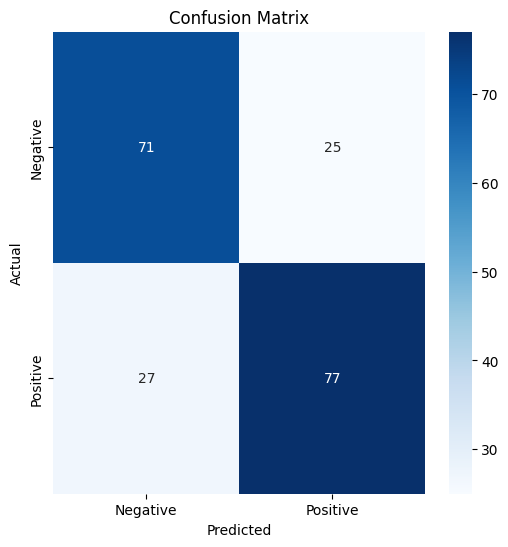

In [4]:
import pandas as pd
import numpy as np
import re
import logging
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# ##################################################
# # Sentiment Analysis for Restaurant Reviews
# ##################################################
#
# This code performs sentiment analysis on restaurant reviews in a TSV fil.
# It has the following steps:
# 1. Load and preprocess the dataset
# 2. Convert text into numerical vectors using CountVectorizer
# 3. Train a Naive Bayes classifier
# 4. Tune hyperparameters using GridSearchCV
# 5. Visualize the confusion matrix
# 6. Evaluate the performance
# 7. Save the trained model for future use
#
# ##################################################


class SentimentAnalysis:
    """
    We create a class to perform sentiment analysis on restaurant reviews.
    """
    def __init__(self, filepath):
        """Initialize with dataset file path."""
        self.filepath = filepath
        self.df = self.load_data()
        self.vectorizer = CountVectorizer()
        self.model = MultinomialNB()

    def load_data(self):
        """Load dataset from a TSV file."""
        df = pd.read_csv(self.filepath, sep='\t')
        logging.info(f'Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns')
        return df

    def preprocess_text(self, text):
        """Clean and preprocess review text."""
        stemmer = PorterStemmer()
        stop_words = set(stopwords.words('english'))
        text = re.sub(r'[^a-zA-Z]', ' ', text)
        text = text.lower().split()
        text = [stemmer.stem(word) for word in text if word not in stop_words]
        return ' '.join(text)

    def prepare_data(self):
        """Apply text preprocessing to dataset."""
        self.df['Processed_Review'] = self.df['Review'].apply(self.preprocess_text)

    def tune_hyperparameters(self, X_train, y_train):
        """Tune hyperparameters using GridSearchCV."""
        param_grid = {
            'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
            'fit_prior': [True, False]
        }
        grid_search = GridSearchCV(self.model, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        logging.info(f'Best Parameters: {grid_search.best_params_}')
        self.model = grid_search.best_estimator_

    def train_model(self):
        """Train the Naive Bayes classifier and evaluate its performance."""
        X = self.vectorizer.fit_transform(self.df['Processed_Review'])
        y = self.df['Liked']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        self.tune_hyperparameters(X_train, y_train)  # Hyperparameter tuning

        self.model.fit(X_train, y_train)

        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        logging.info(f'Model Accuracy: {accuracy:.4f}')
        logging.info('Classification Report:\n' + classification_report(y_test, y_pred))

        print(f'Model Accuracy: {accuracy:.4f}')
        print('Classification Report:\n', classification_report(y_test, y_pred))

        # Confusion Matrix Visualization
        self.plot_confusion_matrix(y_test, y_pred)

    def plot_confusion_matrix(self, y_test, y_pred):
        """Plot confusion matrix."""
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def save_model(self):
        """Save the trained model and vectorizer for future use."""
        with open('sentiment_model.pkl', 'wb') as f:
            pickle.dump((self.model, self.vectorizer), f)
        logging.info('Model saved successfully.')


# ##################################################
# # Execute Sentiment Analysis
# ##################################################
filepath = '/content/Restaurant_Reviews.tsv'  # Update the file path
sentiment_analysis = SentimentAnalysis(filepath)
sentiment_analysis.prepare_data()
sentiment_analysis.train_model()
sentiment_analysis.save_model()